This file does in-depth analysis on 1% data

In [1]:
import os
import codecs
import json
import spacy
import numpy as np
import pandas as pd
import itertools as it
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

No handlers could be found for logger "gensim.models.word2vec"


In [2]:
# pulls reviews and stars from json and saves as a text file
data_directory = os.path.join('dataset')
review_filepath = os.path.join(data_directory,'reviews2.json')
result_directory = os.path.join('result-3categories-minidata-v2')
review_txt_filepath = os.path.join(result_directory,'review_text.txt')
star_txt_filepath = os.path.join(result_directory,'star_text.txt')
# review_count = 0
# with codecs.open(star_txt_filepath, 'w', encoding='utf_8') as star_txt_file:
#     with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:
#         with codecs.open(review_filepath, encoding='utf_8') as review_file:
#             for review_json in review_file:
#                 review = json.loads(review_json)
#                 review_txt_file.write(review[u'text'].replace('\n', ' ').replace('\r', ' ') + '\n')
#                 if (review[u'stars'] == 1) or (review[u'stars'] == 2):
#                     star_txt_file.write('1' + '\n')
#                 if (review[u'stars'] == 3):
#                     star_txt_file.write('2' + '\n')
#                 if  (review[u'stars'] == 4) or (review[u'stars'] == 5):
#                     star_txt_file.write('3' + '\n')
#                 review_count += 1

In [3]:
nlp = spacy.load('en')

In [4]:
def punct_space(token):
    return token.is_punct or token.is_space

def line_review(filename):
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [5]:
unigram_sentences_filepath = os.path.join(result_directory,'unigram_sentences_all.txt')

In [7]:
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence + '\n')

In [9]:
# converts review texts into unigram
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [10]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print u' '.join(unigram_sentence)
    print u''

they have about 20+ thing on tap

and if you do not count thing that be not beer e.g. bud they still have about 12+ beer on tap

that make me really happy

the casual pizza/beer atmosphere be wonderful for a late dinner last night

the folk be really nice and the customer be not super crazy either like you would expect sometimes in a college town

also they have thing like pool table and arcade machine which make them pretty awesome in my book

the pizza be really good

we have a special pizza with feta tomato and basil and a basket of fried mushroos and zuccini

the wait be reasonable for a pizza make from scratch

the pizza be delicious but surprisingly not fill



In [5]:
bigram_model_filepath = os.path.join(result_directory, 'bigram_model_all')

In [6]:
%%time

# bigram_model = Phrases(unigram_sentences)
# bigram_model.save(bigram_model_filepath)

bigram_model = Phrases.load(bigram_model_filepath)

CPU times: user 128 ms, sys: 28 ms, total: 156 ms
Wall time: 155 ms


In [7]:
bigram_sentences_filepath = os.path.join(result_directory,'bigram_sentences_all.txt')

In [13]:
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:

    for unigram_sentence in unigram_sentences:

        bigram_sentence = u' '.join(bigram_model[unigram_sentence])

        f.write(bigram_sentence + '\n')

In [14]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [15]:
# creates a bigram file
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print u' '.join(bigram_sentence)
    print u''

they have about 20+ thing on_tap

and if_you do not count thing that be not beer e.g. bud they still have about 12+ beer on_tap

that make me really happy

the casual pizza/beer atmosphere be wonderful for a late dinner last_night

the folk be really nice and the customer be not super crazy either like you would expect sometimes in a college_town

also they have thing like pool_table and arcade machine which make them pretty awesome in my book

the pizza be really good

we have a special pizza with feta tomato and basil and a basket of fried mushroos and zuccini

the wait be reasonable for a pizza make from_scratch

the pizza be delicious but surprisingly not fill



In [5]:
bigram_reviews_filepath = os.path.join(result_directory,'bigram_transformed_reviews_all.txt')

In [17]:
with codecs.open(bigram_reviews_filepath, 'w', encoding='utf_8') as f:

    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                  batch_size=10000, n_threads=4):

        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                          if not punct_space(token)]

        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]

        # remove any remaining stopwords
        bigram_review = [term for term in bigram_review
                          if term not in spacy.en.STOPWORDS]

        # write the transformed review as a line in the new file
        bigram_review = u' '.join(bigram_review)
        f.write(bigram_review + '\n')

In [18]:
print u'Original:' + u'\n'

for review in it.islice(line_review(review_txt_filepath), 250, 260):
    print review

print u'----' + u'\n'
print u'Transformed:' + u'\n'

with codecs.open(bigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 250, 260):
        print review

Original:

this is my favorite korean restaurant in the south of the campus. I like the spicy mackarel soup. the taste is so delicious.

I was pleasantly surprised by the kalbi and purple rice...it reminded me of my favorite Korean place when I lived in Hawaii.  This place used to have wraps and sandwiches, but have since changed menu and maybe ownership.  The waitress who serves me here is always super nice and makes me feel welcome.  When I'm done here I like to cap it off with Yogurt Park...super convenience.

The food in my opinion is delicious.  It reminds me of home sorta, back from the SGV in SoCal, where Tofu Houses and All You Can Eat KBBQ are a common sight.   Reminiscing aside, I've had their Spicy (Beef) Bulgolgi, their spicy beef hot pot (with noodles), and their kimchi ramen.  All of them, to me, were delicious and filling (albeit the noodles didn't tide my stomach over long enough apparently? that's just a function of being mostly carbs as opposed to having some meat in 

In [15]:
trigram_model_filepath = os.path.join(result_directory,'trigram_model_all')

In [16]:
trigram_model = Phrases(bigram_sentences)

trigram_model.save(trigram_model_filepath)
    
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)

In [17]:
trigram_sentences_filepath = os.path.join(result_directory,'trigram_sentences_all.txt')

In [18]:
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:

    for bigram_sentence in bigram_sentences:

        trigram_sentence = u' '.join(trigram_model[bigram_sentence])

        f.write(trigram_sentence + '\n')

In [19]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [20]:
for trigram_sentence in it.islice(trigram_sentences, 230, 240):
    print u' '.join(trigram_sentence)
    print u''

they have about 20+ thing on_tap

and if_you do_not count thing that be not beer e.g. bud they still have about 12+ beer_on_tap

that make me really happy

the casual pizza/beer atmosphere be wonderful for a late dinner last_night

the folk be really nice and the customer be not super crazy either like you would expect sometimes in a college_town

also they have thing like pool_table and arcade machine which make them pretty awesome in my_book

the pizza be really good

we have a special pizza with feta tomato and basil and a basket of fried mushroos and zuccini

the wait be reasonable for a pizza make from_scratch

the pizza be delicious but surprisingly not fill



In [30]:
trigram_reviews_filepath = os.path.join(result_directory,'trigram_transformed_reviews_all.txt')

In [22]:
with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:

    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                  batch_size=10000, n_threads=4):

        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                          if not punct_space(token)]

        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]

        # remove any remaining stopwords
        trigram_review = [term for term in trigram_review
                          if term not in spacy.en.STOPWORDS]

        # write the transformed review as a line in the new file
        trigram_review = u' '.join(trigram_review)
        f.write(trigram_review + '\n')

In [23]:
print u'Original:' + u'\n'

for review in it.islice(line_review(review_txt_filepath), 3645, 3646):
    print review

print u'----' + u'\n'
print u'Transformed:' + u'\n'

with codecs.open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 3645, 3646):
        print review

Original:

The Free Speech Movement Cafe has Mario Savio's immortal words etched in metal that you can read while waiting in line:  "To me, freedom of speech is something that represents the very dignity of what a human being is. ... It is the thing that marks us as just below the angels."  That being said, FSM is the second-best cafe in Berkeley to engage in that practice known as "eye-f*cking."  Any student who has ever sat in a cafe to study during midterms has done it.  You're sitting at a table, enjoying your hot grilled chicken panini and fresh green salad, allowing your Americano to cool, when you see an attractive person sitting across the way from you.  S/he is typing away at a laptop, but every so often--so you think--s/he looks up and gazes intently into your eyes.  Maybe s/he is looking THROUGH you to the grayscale images of the Free Speech Movement behind you; maybe the person is simply seeking the camaraderie of another weary, exam-riddled soul.  But you know better.  S/h

In [6]:
# uses bigram to create X
X_list=pd.read_table(bigram_reviews_filepath, skip_blank_lines=False ,names=['text'])
X=X_list.text

In [7]:
# assign ratings as y values
y_list=pd.read_table(star_txt_filepath,names=['stars'])
y=y_list.stars

In [21]:
print X.shape
print y.shape

(17396,)
(17396,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [11]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(X.values.astype('U'))
# X_train_dtm = vect.fit_transform(X_train.values.astype('U'))
# X_test_dtm = vect.transform(X_test.values.astype('U'))
# X_test_dtm2 = vect.transform(["ddgdhrrrgh00"])

In [33]:
# cross_val to get accuracy and f1-score for naive-bayse
from sklearn.cross_validation import cross_val_score
nb = MultinomialNB()
scores = cross_val_score(nb,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nb,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.67672414  0.63534483  0.65948276  0.68123024  0.63215416]
Accuracy: 0.66 (+/- 0.04)
f1: 0.66 (+/- 0.04)


In [19]:
# cross_val to get accuracy and f1-score for svm
from sklearn import svm
svc=svm.SVC(kernel='linear',C= 0.01, class_weight= None)
scores = cross_val_score(svc,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svc,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.69770115  0.67385057  0.68706897  0.68784133  0.67213115]
Accuracy: 0.68 (+/- 0.02)
f1: 0.68 (+/- 0.02)


In [17]:
# cross_val to get accuracy and f1-score for random-forest
from sklearn.cross_validation import cross_val_score
rf=RandomForestClassifier(min_samples_split=2, n_estimators=50, bootstrap=False, criterion='entropy', max_depth=None)
scores = cross_val_score(rf,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(rf,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.67873563  0.66350575  0.66752874  0.65938488  0.65976416]
Accuracy: 0.67 (+/- 0.01)
f1: 0.66 (+/- 0.02)


In [21]:
# cross_val to get accuracy and f1-score for naive-bayse adaboost
nb = MultinomialNB()
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(nb)
scores = cross_val_score(ab,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(ab,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.6637931   0.61350575  0.56522989  0.67346939  0.53551913]
Accuracy: 0.61 (+/- 0.11)
f1: 0.61 (+/- 0.11)


In [22]:
vect = TfidfVectorizer()
X_dtm = vect.fit_transform(X.values.astype('U'))

In [23]:
# cross_val to get accuracy and f1-score for naive-bayse adaboost, but this time use ft-idf vectorizer instead
nb = MultinomialNB()
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(nb)
scores = cross_val_score(ab,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(ab,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.59798851  0.59798851  0.59798851  0.59787295  0.59821685]
Accuracy: 0.60 (+/- 0.00)
f1: 0.60 (+/- 0.00)


In [24]:
nb = MultinomialNB()
scores = cross_val_score(nb,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nb,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.6         0.60114943  0.60086207  0.59959759  0.60023008]
Accuracy: 0.60 (+/- 0.00)
f1: 0.60 (+/- 0.00)


In [37]:
print metrics.classification_report(y_test, y_pred_nb)
print metrics.confusion_matrix(y_test, y_pred_nb)

             precision    recall  f1-score   support

          1       0.68      0.50      0.58       751
          2       0.45      0.38      0.41       997
          3       0.76      0.87      0.81      2601

avg / total       0.68      0.69      0.68      4349

[[ 374  194  183]
 [ 103  380  514]
 [  69  276 2256]]


In [110]:
y.value_counts()/len(y)

3    0.598011
2    0.229306
1    0.172683
Name: stars, dtype: float64

In [111]:
rf=RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_pred_rf = rf.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_rf)

0.646125546103


In [112]:
from sklearn import svm
svc=svm.SVC()
svc.fit(X_train_dtm, y_train)
y_pred_svm = svc.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_svm)

0.598068521499


In [35]:
from sklearn.grid_search import GridSearchCV
param_grid = {'alpha': [0,.5,1],
              'fit_prior': [True,False]}
nb_rf = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5)
nb_rf.fit(X_train_dtm, y_train)
nb_rf.best_params_
print nb_rf.best_params_

{'alpha': 1, 'fit_prior': True}


In [113]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_nb = nb.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_nb)

0.692113129455


In [37]:
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [3, 5, 10, None],
              'min_samples_split': [2, 5],
              'criterion': ['gini', 'entropy'],
              'bootstrap': [True, False]}
gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
gs_rf.fit(X_train_dtm, y_train)
gs_rf.best_params_
print gs_rf.best_params_

{'min_samples_split': 2, 'n_estimators': 100, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}


In [114]:
rf=RandomForestClassifier(min_samples_split=2, n_estimators=50, bootstrap=False, criterion='entropy', max_depth=None)
rf.fit(X_train_dtm, y_train)
y_pred_class = rf.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_class)

0.673258220281


In [39]:
param_grid = {'C': [0.01, 0.1, 1, 10],
              'class_weight': [None,'balanced']}
gs_svc = GridSearchCV(svm.SVC(kernel='linear'), param_grid)
gs_svc.fit(X_train_dtm, y_train)
gs_svc.best_params_
print gs_svc.best_params_

{'C': 0.1, 'class_weight': None}


In [40]:
svc=svm.SVC(kernel='linear',C= 0.01, class_weight= 'balanced')
svc.fit(X_train_dtm, y_train)
y_pred_class = svc.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_class)

0.673258220281


In [127]:
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import cross_val_score

bagging = BaggingClassifier(nb)
# bagging.fit(X_train_dtm,y_train)
# y_pred_bag = bagging.predict(X_test_dtm)
# print metrics.accuracy_score(y_test, y_pred_bag)
print "Bagging Score:\t", cross_val_score(bagging, X_train_dtm,y, cv=5, n_jobs=-1).mean()

Bagging Score:	0.658021376002


In [125]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(nb)
# ab.fit(X_train_dtm,y_train)
# y_pred_fit = ab.predict(X_test_dtm)
print cross_val_score(ab, X_train_dtm, y, cv=5, n_jobs=-1).mean()

0.610303449814


In [117]:
print "Bagging Score:\t", cross_val_score(nb, X_train_dtm,y_train, cv=5, n_jobs=-1).mean()

Bagging Score:	0.691652547384


In [121]:
X_list=pd.read_table(bigram_reviews_filepath, skip_blank_lines=False ,names=['text'])
X=X_list.text

In [122]:
y_list=pd.read_table(star_txt_filepath,names=['stars'])
y=y_list.stars

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [123]:
# tf-idf
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X.values.astype('U'))
X_test_dtm = vect.transform(X_test.values.astype('U'))
# X_test_dtm2 = vect.transform(["ddgdhrrrgh00"])

In [42]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_nb = nb.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_nb)
#print y_pred_class

0.707059094045


In [43]:
print X_train_dtm.shape
print y.shape

(13047, 23785)
(17396,)


In [44]:
print metrics.classification_report(y_test, y_pred_nb)
print metrics.confusion_matrix(y_test, y_pred_nb)

             precision    recall  f1-score   support

          1       0.70      0.55      0.61       735
          2       0.48      0.36      0.41      1031
          3       0.77      0.89      0.82      2583

avg / total       0.69      0.71      0.69      4349

[[ 402  175  158]
 [ 112  374  545]
 [  60  224 2299]]


In [24]:
# change parameters
vect = CountVectorizer(min_df=0.01)
X_dtm = vect.fit_transform(X.values.astype('U'))

In [25]:
from sklearn.cross_validation import cross_val_score
nb = MultinomialNB()
scores = cross_val_score(nb,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nb,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.66724138  0.6         0.65143678  0.68554182  0.60339373]
Accuracy: 0.64 (+/- 0.07)
f1: 0.64 (+/- 0.07)


In [70]:
result_directory

'result-3categories-minidata-v2'

In [73]:
sentiment=[]
review_filepath = os.path.join(result_directory,'review_text.txt')
with codecs.open(review_filepath, 'r', encoding='utf_8') as review_file:
    for sentence in review_file:
        blob=TextBlob(sentence)
        sentiment.append(blob.sentiment.polarity)

In [75]:
len(sentiment)

17396

In [76]:
X.shape

(17396,)

In [89]:
# yelp sentiment detector vs textblob sentiment detector
np.corrcoef(sentiment,y)

array([[ 1.       ,  0.4116895],
       [ 0.4116895,  1.       ]])

Confusion matrix, without normalization
[[ 374  194  183]
 [ 103  380  514]
 [  69  276 2256]]


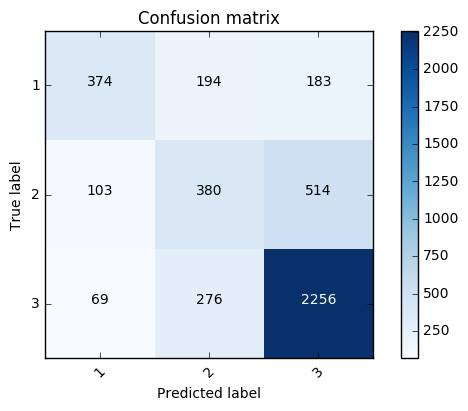

In [135]:
# better visualizaion for confusion matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3],
                      title='Confusion matrix')